In [295]:
#%cd ../..

In [37]:
from sklearn.metrics import (
    f1_score, 
    confusion_matrix, 
    make_scorer, 
    accuracy_score, 
    recall_score,
    r2_score
)
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate
from fairlearn.metrics import (
    count,
    selection_rate,
    equalized_odds_difference,
    false_positive_rate,
    false_negative_rate,
    demographic_parity_difference,
    MetricFrame,
    true_negative_rate,
    true_positive_rate
)

from graphs import (
    create_df_ranges, 
    eval_metrics_graph, 
    fig_train_test, 
    create_df_groups_metric,
    create_df_metrics, 
    pareto_fig, 
    comparison_graph, 
    graph_eval_groups, 
    graph_eval_groups_metric,
    indicators,
    graph_opt_orig,
    graph_fair_opt_orig,
    create_df_groups_metrics
)

from metrics import (
    equality_opportunity_difference, 
    predictive_equality_difference, 
    metric_evaluation, 
    get_metric_evaluation,
    mse,
    mae,
    nmse,
    nmae
)

from fairlearn.datasets import fetch_adult
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from metrics import equality_opportunity_difference, predictive_equality_difference, metric_evaluation, get_metric_evaluation
from sklearn.utils import resample
import tqdm as notebook_tqdm
import matplotlib.pyplot as plt

import dill
import optuna
import plotly
import numpy as np
import optuna
import seaborn as sns

In [38]:
file_name = 'results/sex/recall-ppv-models-motpe-succesivehalving-parallel-150trials-4sim-results.pkl'
with open(file_name, 'rb') as in_strm:
    results = dill.load(in_strm)

In [39]:
#results

In [40]:
fair_metric_name = 'Predictive Equality Difference'
model_metric_name = 'Recall'
fair_col = 'predictive equality'
model_col = 'recall'

In [41]:
fair_metrics_dict = {} 
fair_metrics_dict['train_fair'] = sum([list(list(zip(*res))[0]) for res in results['res_sim']], [])

model_metrics_dict = {} 
model_metrics_dict['train_model'] = sum([list(list(zip(*res))[1]) for res in results['res_sim']], [])

In [42]:
fair_metrics = [
    'demographic parity',
    'predictive parity',
    'equality opportunity',
    'predictive equality', 
    'average absolute odds',
    ]

metrics = [
    'recall', 
    'precision',
    'f1 score',
    'accuracy'
]


model_metrics_u_dict = {}
fair_metrics_u_dict = {}

for metric in fair_metrics:
    fair_metrics_dict[metric] = [get_metric_evaluation(metric_frame)[metric] for res in results['metrics_sim'] for metric_frame in res]
    fair_metrics_u_dict[metric] = [get_metric_evaluation(metric_frame)[metric] for res in results['metrics_sim_u'] for metric_frame in res]

for metric in metrics:
    model_metrics_dict[metric] = [metric_frame.overall[metric] for res in results['metrics_sim'] for metric_frame in res]
    model_metrics_u_dict[metric] = [metric_frame.overall[metric] for res in results['metrics_sim_u'] for metric_frame in res]


In [43]:
import pandas as pd 

def create_df_metrics(fair_metrics, model_metrics, results):
    df_fair = pd.DataFrame.from_dict(fair_metrics)
    df_model = pd.DataFrame.from_dict(model_metrics)
    df_metrics = pd.concat([df_fair,df_model], axis = 1)
    df_metrics['sim'] = sum([[i]*len(res) for i,res in enumerate(results['res_sim'])],[])
    return df_metrics

df_metrics = create_df_metrics(fair_metrics_dict, model_metrics_dict, results)

In [44]:
df_metrics['model'] = sum(results['models_sim'],[])
df_metrics = df_metrics[df_metrics['train_model'] != 0]
df_metrics_sorted = df_metrics.sort_values(['train_fair','sim'])
new_index = df_metrics_sorted.index
df_metrics_sorted = df_metrics_sorted.reset_index(drop = True)

In [45]:
def result_metrics(df_metrics, train_col, test_col):
    metrics = {}
    mse = df_metrics.groupby(['sim']).apply(lambda x: nmse(x, train_col = train_col,test_col = test_col))
    corr = df_metrics.groupby(['sim']).apply(lambda x: x[train_col].corr(x[test_col], method='spearman'))
    r2 = df_metrics.groupby(['sim']).apply(lambda x: r2_score(x[train_col],x[test_col]))
    for name,metric in zip(['mse','corr','r2'],[mse,corr,r2]):
        metrics[f'{name}_mean'] = metric.mean()
        metrics[f'{name}_std'] = metric.std()
    return metrics


In [46]:
df_metrics.groupby(['sim']).apply(lambda x: nmse(x, train_col = 'train_fair',test_col = fair_col))

sim
0    0.091494
1    0.147762
2    0.170847
3    0.092024
dtype: float64

In [47]:
df_metrics.groupby(['sim']).apply(lambda x: nmse(x, train_col = 'train_model',test_col = model_col))

sim
0    0.073814
1    0.035622
2    0.039419
3    0.036268
dtype: float64

In [48]:
pd.DataFrame.from_dict(result_metrics(df_metrics_sorted, train_col = 'train_fair', test_col = fair_col), orient = 'index')

,0
mse_mean,0.125532
mse_std,0.040120
corr_mean,0.980802
corr_std,0.012549
r2_mean,0.732421
r2_std,0.141708


In [49]:
pd.DataFrame.from_dict(result_metrics(df_metrics_sorted, train_col = 'train_model', test_col = model_col), orient = 'index')

,0
mse_mean,0.046281
mse_std,0.018430
corr_mean,0.975014
corr_std,0.009455
r2_mean,0.953165
r2_std,0.034134


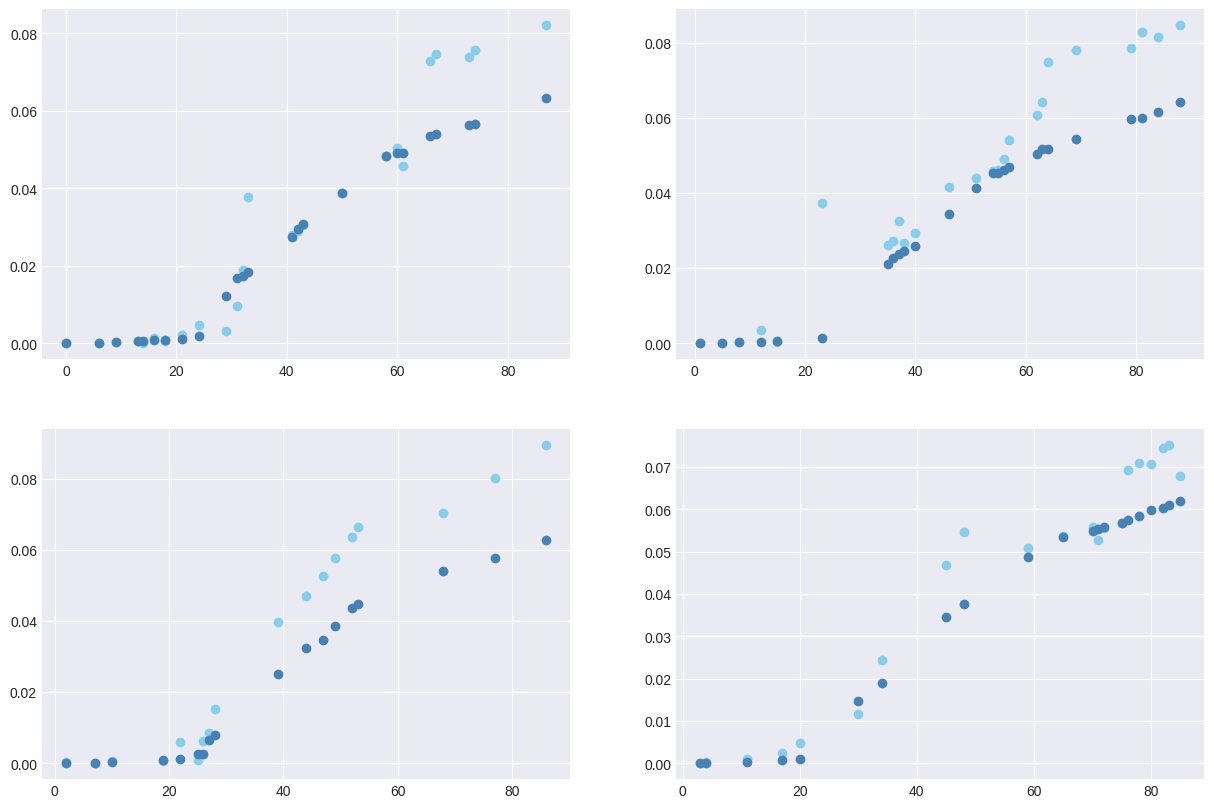

In [313]:
plt.style.use('seaborn-v0_8-darkgrid')
rows = 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(15,10))
for i,ax in zip(range(df_metrics_sorted['sim'].max()+1),axes.ravel()):
    ax.scatter(df_metrics_sorted[df_metrics_sorted['sim'] == i].index, 
               df_metrics_sorted.loc[df_metrics_sorted['sim'] == i, fair_col],
               color = '#87CEEB')
    ax.scatter(df_metrics_sorted[df_metrics_sorted['sim'] == i].index, 
               df_metrics_sorted.loc[df_metrics_sorted['sim'] == i, 'train_fair'],
               color = '#4682B4')
    

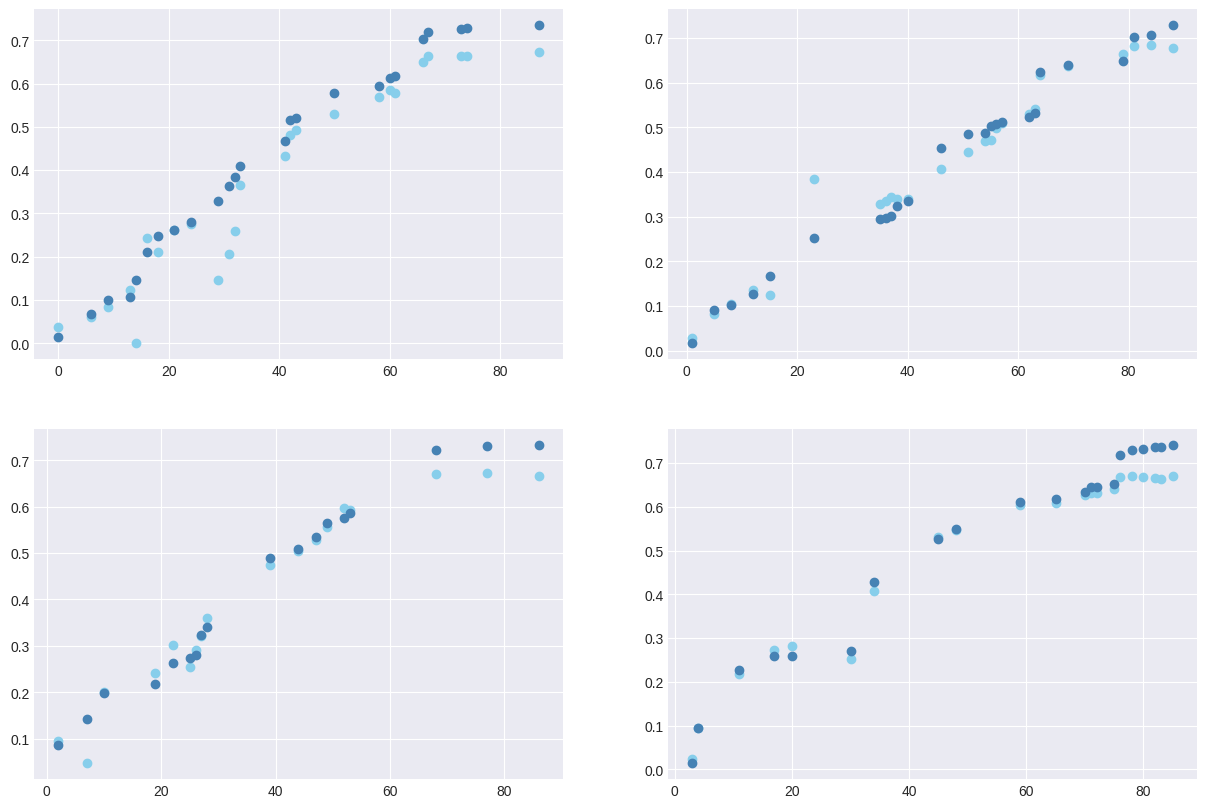

In [314]:
plt.style.use('seaborn-v0_8-darkgrid')
rows = 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(15,10))
for i,ax in zip(range(df_metrics_sorted['sim'].max()+1),axes.ravel()):
    ax.scatter(df_metrics_sorted[df_metrics_sorted['sim'] == i].index, 
               df_metrics_sorted.loc[df_metrics_sorted['sim'] == i, model_col],
               color = '#87CEEB')
    ax.scatter(df_metrics_sorted[df_metrics_sorted['sim'] == i].index, 
               df_metrics_sorted.loc[df_metrics_sorted['sim'] == i, 'train_model'],
               color = '#4682B4')

In [315]:
n_sim = 1
fair_metrics = [
    'demographic parity',
    'predictive parity',
    'equality opportunity',
    'predictive equality', 
    'average absolute odds',
    ]

metrics = [
    'recall', 
    'precision',
    'f1 score',
    'accuracy'
]

model_metrics_dict = {}
model_metrics_u_dict = {}
fair_metrics_dict = {}
fair_metrics_u_dict = {}

fair_metrics_dict['train_fair'],_ = list(zip(*results['res_sim'][n_sim]))
for metric in fair_metrics:
    fair_metrics_dict[metric] = [get_metric_evaluation(metric_frame)[metric] for metric_frame in results['metrics_sim'][n_sim]]
    fair_metrics_u_dict[metric] = [get_metric_evaluation(metric_frame)[metric] for metric_frame in results['metrics_sim_u'][n_sim]]

_,model_metrics_dict['train_model'] = list(zip(*results['res_sim'][n_sim]))
for metric in metrics:
    model_metrics_dict[metric] = [metric_frame.overall[metric] for metric_frame in results['metrics_sim'][n_sim]]
    model_metrics_u_dict[metric] = [metric_frame.overall[metric] for metric_frame in results['metrics_sim_u'][n_sim]]

def create_df_metrics(fair_metrics, model_metrics):
    df_fair = pd.DataFrame.from_dict(fair_metrics)
    df_model = pd.DataFrame.from_dict(model_metrics)
    df_metrics = pd.concat([df_fair,df_model], axis = 1)
    return df_metrics

df_metrics = create_df_metrics(fair_metrics_dict, model_metrics_dict)
df_metrics['model'] = results['models_sim'][n_sim]
df_metrics = df_metrics[df_metrics['train_model'] != 0]
df_metrics_sorted = df_metrics.sort_values(['train_fair'])
new_index = df_metrics_sorted.index
df_metrics_sorted = df_metrics_sorted.reset_index(drop = True)


In [316]:
#results['metrics_sim'][0][12].by_group

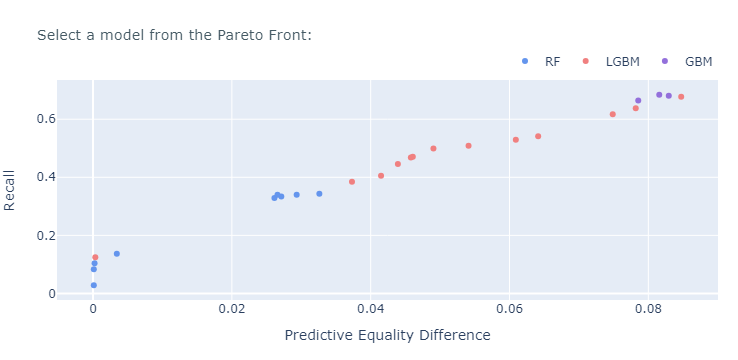

In [317]:
colors = ['CornflowerBlue','LightCoral','MediumPurple','SandyBrown','lightseagreen']

train_fair_col = 'train_fair'
train_model_col = 'train_model'

fair_mse = np.round(nmse(df_metrics_sorted, train_fair_col, fair_col),3)
model_mse = np.round(nmse(df_metrics_sorted, train_model_col, model_col),3)

pareto_fig(df_metrics_sorted, fair_col, model_col, fair_metric_name, model_metric_name, colors)

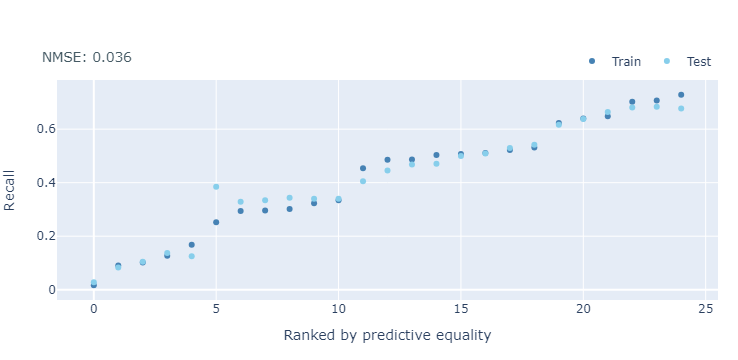

In [318]:
fig_train_test(
    df_metrics_sorted,
    metric_title = model_metric_name,
    train_col = train_model_col,
    test_col =  model_col,
    ranking_metric= fair_col,
    metric_result = model_mse)


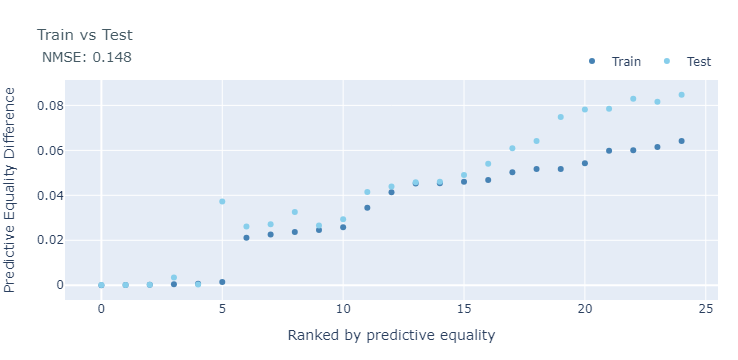

In [319]:
fig_train_test(
    df_metrics_sorted,
    metric_title = fair_metric_name,
    train_col = train_fair_col,
    test_col = fair_col,
    ranking_metric = fair_col,
    title = 'Train vs Test',
    metric_result = fair_mse)